In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats

In [3]:
data = pd.read_csv('The_Tax_Burden_on_Tobacco__1970-2017.csv')


In [4]:
# states = data['LocationDesc'].unique()
statesid = data['LocationAbbr'].unique()
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']

controlstates = []


ils, sil = {}, {}
for i in range(len(statesid)):
    ils[i] = statesid[i]
    sil[statesid[i]] = i
    if statesid[i] in sskip: continue
    else: controlstates.append(statesid[i])

In [5]:
consumption = 'Cigarette Consumption (Pack Sales Per Capita)'
sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']

# Setup

In [6]:
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')

nyears = years.size
i1 = 18
yearspred =  years[i1:]
yy = years.size


In [7]:
statesales = {}
statecosts = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')
    loc = costs['LocationAbbr'] == s
    statecosts[s] = costs[loc]['Data_Value'].values.astype('float32')
# ss = 'CO'
# tmp = statesales['CA'].copy()
# statesales['CA'] = statesales[ss].copy()
# statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    salearray[i] = statesales[ils[i]]
    
costarray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    costarray[i] = statecosts[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

# costarrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: costarrayca.append(statecosts[ils[i]])
# costarrayca = np.array(costarrayca)
costarrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: costarrayskip.append(statecosts[ils[i]])
costarrayskip = np.array(costarrayskip)
costarrayca = costarrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)
meansalesskip = salearrayskip.mean(axis=0)
cacosts = statecosts['CA']
meancosts = costarrayca.mean(axis=0)
meancostsskip = costarrayskip.mean(axis=0)



# Synth

In [8]:
from scipy.optimize import fmin_slsqp, minimize

def basic_dataprep(predictors_matrix, outcomes_matrix, 
             treated_unit, control_units, predictors_optimize, 
             outcomes_optimize, years_plot):
    print('\nDo data prep\n')
#     # check if data types match expectations.
#     if not type(predictors_matrix) == pd.core.frame.DataFrame:
#         raise NameError("Error 1")
#     elif not type(outcomes_matrix) == pd.core.frame.DataFrame:
#         raise NameError("Error 2")
#     elif not type(treated_unit) == str:
#         raise NameError("Error 3")
#     elif not type(control_units) == list:
#         raise NameError("Error 4")
#     elif not type(predictors_optimize) == list:
#         raise NameError("Error 5")
#     elif not type(outcomes_optimize) == list:
#         raise NameError("Error 6")
#     elif not type(years_plot) == list:
#         raise NameError("Error 7")
    
#     # check for empty lists
#     if len(control_units) == 0 or len(predictors_optimize) == 0 or len(outcomes_optimize) == 0:
#            raise NameError("Error 8")
    
#     # check for whether there are repeated control units, or more controls
#     # than columns in the input matrices.  
#     if len(control_units) >= predictors_matrix.shape[1] or len(control_units) >= outcomes_matrix.shape[1]:
#             print(len(control_units), predictors_matrix.shape[1], outcomes_matrix.shape[1])
#             raise NameError("Error 9")

    # if the list of controls contains the treated unit, remove treated unit.
    while treated_unit in control_units:
        control_units.remove(treated_unit)

        
    
    try:
        X1 = predictors_matrix.loc[predictors_optimize][treated_unit]
        del predictors_matrix[treated_unit]
        X0 = predictors_matrix.loc[predictors_optimize][control_units]
        print('No exception')
    except Exception as e:
        print('Exception : ', e)
        X1, X0 = None, None
    
    Z3 = outcomes_matrix.loc[years_plot][treated_unit]
    Z2 = outcomes_matrix.loc[years_plot][control_units]
    Z1 = outcomes_matrix.loc[outcomes_optimize][treated_unit]
    Z0 = outcomes_matrix.loc[outcomes_optimize][control_units]
             
    return X0, X1, Z0, Z1, Z2, Z3


def w_rss(w, v, x0, x1):
    k = len(x1)
    importance = np.zeros((k,k))
    np.fill_diagonal(importance, v)
    predictions = np.dot(x0, w)
    errors = x1 - predictions
    weighted_errors = np.dot(errors.transpose(), importance)
    try: weighted_rss = np.dot(weighted_errors,errors).item(0)
    except: weighted_rss = np.dot(weighted_errors,errors)
    return weighted_rss


def v_rss(w, z0, z1):
    predictions = np.dot(z0,w)
    errors = z1 - predictions
    rss = sum(errors**2)
    return rss


def get_v_0(v, w, x0, x1, z0, z1):
    weights = fmin_slsqp(w_rss, w, f_eqcons=w_constraint, bounds=[(0.0, 1.0)]*len(w),
             args=(v, x0, x1), disp=0, full_output=True, iter=1000, acc=1e-7)[0]
    rss = v_rss(weights, z0, z1)
    return rss
    
def get_v_1(v, w, x0, x1, z0, z1):
    result = minimize(get_v_0, v, args=(w, x0, x1, z0, z1), bounds=[(0.0, 1.0)]*len(v), options={'maxiter':5000, 'maxfev':10000})
    importance = result.x
    return importance
    

def w_constraint(w, v, x0, x1):
    return np.sum(w) - 1


def w_constraintnopred(w, x0, x1):
    return np.sum(w) - 1
    

def get_w(w, v, x0, x1):
    result = fmin_slsqp(w_rss, w, f_eqcons=w_constraint, bounds=[(0.0, 1.0)]*len(w),
             args=(v, x0, x1), disp=1, full_output=True, iter=1000, acc=1e-7)
    weights = result[0]
    return weights


def get_estimate(x0, x1, z0, z1, z2):
    print('z0.shape, z1.shape, z2.shape: ',  z0.shape, z1.shape, z2.shape)
    if x0 is not None: print('x0.shape, x1.shape : ', x0.shape, x1.shape)
    
    j = z0.shape[1]
    w = np.array([1.0/j]*j)
    use_predictors = True
    if x1 is not None: k = len(x1)
    else: use_predictors = False
    if use_predictors:
        print('Use predictors')
        v = [1.0/k]*k
        print('len(v), w.shape : ',len(v), w.shape)
        predictors = get_v_1(v, w, x0, x1, z0, z1)
        controls = get_w(w, predictors, x0, x1)
        z_estimates = np.dot(z2,controls)
        return z_estimates, predictors, controls
    else:
        print('Do not use predictors')
        v = None
        print('len(v), w.shape : ',v, w.shape)
#         controls = fmin_slsqp(v_rss, w, f_eqcons=w_constraintnopred, bounds=[(0.0, 1.0)]*len(w),
#              args=(z0, z1), disp=False, full_output=True)[0]
        controls = minimize(v_rss, w, args=(z0, z1), constraints={'type':'eq', 'fun': lambda t: np.sum(t) - 1},  bounds=[(0.0, 1.0)]*len(w)).x
        z_estimates = np.dot(z2,controls)
        return z_estimates, None, controls

    
def synth_tables(predictors_matrix, outcomes_matrix, treated_unit, control_units, 
    predictors_optimize, outcomes_optimize, years_plot):
    
    if predictors_matrix is not None:
        preds, outcomes = predictors_matrix.copy(), outcomes_matrix.copy()
    else:
        preds, outcomes = None, outcomes_matrix.copy()
        
    X0, X1, Z0, Z1, Z2, Z3 = basic_dataprep(preds, outcomes,
        treated_unit, control_units, predictors_optimize, outcomes_optimize, 
        years_plot)
        
    estimates, predictors, controls = get_estimate(X0, X1, Z0, Z1, Z2)
#     float:right
    if predictors is not None:
        estimated_predictors = np.dot(X0,controls)
        predictors_table = pd.DataFrame({'Synthetic':estimated_predictors, 'Actual': X1},index=X1.index)
    else: predictors_table = None
    
    estimated_outcomes = np.dot(Z2,controls)
    outcomes_table = pd.DataFrame({'Synthetic':estimated_outcomes, 'Actual':Z3},index=Z3.index)

    
    return estimates, Z3, predictors_table, outcomes_table, predictors, controls
    


(4, 6) (7, 6)

Do data prep

No exception
z0.shape, z1.shape, z2.shape:  (5, 5) (5,) (7, 5)
x0.shape, x1.shape :  (5, 5) (5,)
Use predictors
len(v), w.shape :  5 (5,)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:82: OptimizeWarning: Unknown solver options: maxfev


Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 1001
            Function evaluations: 17007
            Gradient evaluations: 1001
   Synthetic  Actual
A        NaN     3.0
B        NaN     1.0
C        NaN     6.0
D        NaN     1.0
E        NaN     NaN

Do data prep

Exception :  'NoneType' object has no attribute 'loc'
z0.shape, z1.shape, z2.shape:  (5, 5) (5,) (7, 5)
Do not use predictors
len(v), w.shape :  None (5,)
None


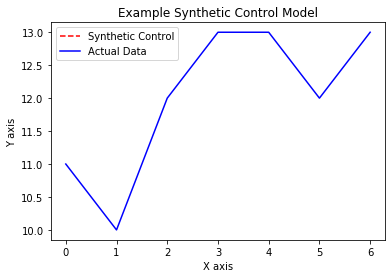

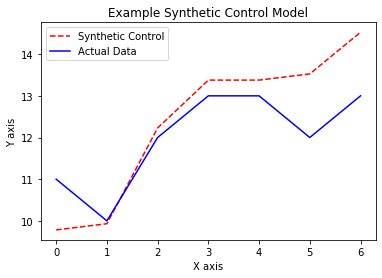

In [9]:
pred = pd.DataFrame({'a':[3,1,6,1], 'b':[4,2,5,0], 'c':[5,2,3,5],
                         'd':[4,2,4,2], 'e': [3,4,7,2], 'f': [4,3,8,2]},index=['A','B','C','D'])

# pred = pd.DataFrame({'a':[3,1,6], 'b':[2,5,0], 'c':[5,3,5],
#                          'd':[4,2,4], 'e': [3,7,2], 'f': [4,8,2]},index=['A','B','C'])
outc = pd.DataFrame({'a':[11,10,12,13,13,12,13], 'b':[8,8,10,11,11,11,12],
                         'c':[20,21,25,27,27,28,29], 'd':[16,17,22,25,25,26,27],
                         'e':[14,14,17,20,21,21,23], 'f':[13,10,12,21,23,19,25]},
                         index=[2010,2011,2012,2013,2014,2015,2016])
    
print(pred.shape, outc.shape)
output = synth_tables( pred,
                       outc,
                       'a',
                       ['b','c','d','e', 'f'],
                       ['A','B','C','D','E'],
                       [2010,2011,2012,2013,2014],[2010,2011,2012,2013,2014,2015,2016]
                     )

print(output[2])

output2 = synth_tables( None,
                       outc,
                       'a',
                       ['b','c','d','e', 'f'],
                       ['A','B','C','D','E'],

                       [2010,2011,2012,2013,2014],[2010,2011,2012,2013,2014,2015,2016]
                     )
print(output2[2])

def plot(synth_tables):
    estimates, actual_values = synth_tables[0], synth_tables[1]
    plt.plot(range(len(estimates)),estimates, 'r--', label="Synthetic Control")
    plt.plot(range(len(estimates)),actual_values, 'b-', label="Actual Data")
    plt.title("Example Synthetic Control Model")
    plt.ylabel("Y axis")
    plt.xlabel("X axis")
    plt.legend(loc='upper left')
    plt.show()

plot(output)
plot(output2)

## Apply to CA

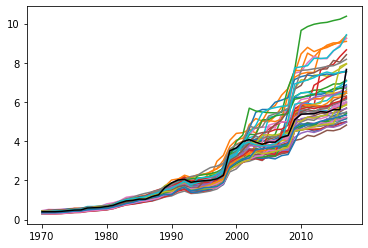

In [10]:
# plt.plot(years, casales)
plt.plot(years, costarray.T)
plt.plot(years, cacosts, 'k')


In [11]:
iyear = 18

subdata = data[data['SubMeasureDesc'] == consumption]
subdata[subdata['Year'] == 1975]['Data_Value'].values

# predictors = pd.DataFrame(index = [1975, 1980, 1988], columns=statesid)
predictors = pd.DataFrame(index = years[:iyear].astype(int), columns=statesid)
outcomes = pd.DataFrame(index = years.astype(int), columns=statesid)

# for iss, ss in enumerate(statesid):{'type':'eq', 'fun': con}
#     predictors.set_value( '1975', ss, subdata[subdata['Year'] == 1975]['Data_Value'].values[iss])
#     predictors.set_value( '1980', ss, subdata[subdata['Year'] == 1980]['Data_Value'].va{'type':'eq', 'fun': con}lues[iss])

# predictors.loc[1975] = subdata[subdata['Year'] == 1975]['Data_Value'].values.astype(float32)
# predictors.loc[1980] = subdata[subdata['Year'] == 1980]['Data_Value'].values.astype(float32)
# predictors.loc[1988] = subdata[subdata['Year'] == 1988]['Data_Value'].values.astype(float32)

costmatrix = []
for iy, yy in enumerate(years):
    outcomes.loc[int(yy)] = subdata[subdata['Year'] == yy]['Data_Value'].values.astype(float32)
    if iy<=iyear: 
        predictors.loc[int(yy)] = subdata[subdata['Year'] == yy]['Data_Value'].values.astype(float32)
        costmatrix.append(costs[costs['Year'] == yy]['Data_Value'].values.astype(float32))
predictors.loc['cost'] = np.array(costmatrix).mean(axis=0)*100


In [12]:
output = synth_tables( predictors,
                       outcomes,
                       'CA',
                       controlstates,
                       [1975, 1980, 1988],
                       list(years[:iyear].astype(int)), list(years.astype(int))
                     )

print('\nDone\n')

outputall = synth_tables( predictors,
                       outcomes,
                       'CA',
                       controlstates,
                       list(years[:iyear].astype(int)),
                       list(years[:iyear].astype(int)), list(years.astype(int))
                     )
print('\nDone\n')

outputcost = synth_tables( predictors,
                       outcomes,
                       'CA',
                       controlstates,
                       [1975, 1980, 1988] +  ['cost'],
                       list(years[:iyear].astype(int)), list(years.astype(int))
                     )
print('\nDone\n')


# outputnone = synth_tables( None,
#                        outcomes,
#                        'CA',
# #                        list(statesid),
#                        list(set(statesid) - set(sskip)),
#                        [1975, 1980, 1988],

#                        list(years[:iyear].astype(int)), list(years.astype(int))
#                      )
# print('\nDone\n')



Do data prep

No exception
z0.shape, z1.shape, z2.shape:  (18, 38) (18,) (48, 38)
x0.shape, x1.shape :  (3, 38) (3,)
Use predictors
len(v), w.shape :  3 (38,)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:82: OptimizeWarning: Unknown solver options: maxfev


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.643840434119666e-11
            Iterations: 7
            Function evaluations: 285
            Gradient evaluations: 7

Done


Do data prep

No exception
z0.shape, z1.shape, z2.shape:  (18, 38) (18,) (48, 38)
x0.shape, x1.shape :  (18, 38) (18,)
Use predictors
len(v), w.shape :  18 (38,)
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.5644889434885054
            Iterations: 11
            Function evaluations: 446
            Gradient evaluations: 11

Done


Do data prep

No exception
z0.shape, z1.shape, z2.shape:  (18, 38) (18,) (48, 38)
x0.shape, x1.shape :  (4, 38) (4,)
Use predictors
len(v), w.shape :  4 (38,)
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.703635290116267e-09
            Iterations: 11
            Function evaluations: 447
            Gradient evaluations: 11

Done



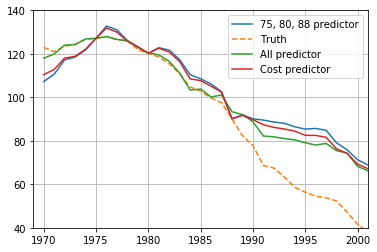

In [13]:
plt.plot(years, output[0], label = '75, 80, 88 predictor')
plt.plot(years, output[1].values, '--', label='Truth')
plt.plot(years, outputall[0], label = 'All predictor')
plt.plot(years, outputcost[0], label = 'Cost predictor')
# plt.plot(years, outputnone[0], label = 'No predictor')
plt.legend()
plt.xlim(1969, 2001)
plt.ylim(40, 140)
plt.grid(which='both')

In [14]:
print(((output[0] - output[1].values)**2)[:iyear].mean()**0.5)
print(((outputall[0] - output[1].values)**2)[:iyear].mean()**0.5)
print(((outputcost[0] - output[1].values)**2)[:iyear].mean()**0.5)

6.385279531305261
1.6013988648927073
5.298932382414423


In [15]:
 np.vstack((controlstates,  output[5].astype('str')))

array([['AK', 'AR', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS',
        'KY', 'LA', 'ME', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NM',
        'NC', 'ND', 'OH', 'OK', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
        'VT', 'VA', 'WV', 'WI', 'WY'],
       ['0.2250377206845229', '0.007402005243812917',
        '0.00743970147206257', '0.009331585480900738',
        '0.012946930350894033', '0.009124216694801774',
        '0.01185486066114195', '0.0074216796393736535',
        '0.03351949535180292', '0.007523774208085735',
        '0.008004073913649035', '0.010192720294812599',
        '0.007438357500180142', '0.01302372568903699',
        '0.007425465516149924', '0.0074142945813347304',
        '0.010202577566999549', '0.007437897646287088',
        '0.008725853982779055', '0.022692706047050336',
        '0.009460326972409986', '0.009216961279798905',
        '0.06641496869934138', '0.0074523163073494806',
        '0.008728681821421884', '0.007450060628848448',
        '0.0074

In [16]:
output[4]

array([0.33333319, 0.33333319, 0.33333362])

In [17]:
predictors_table, outcomes_table, predictors, controls

NameError: name 'predictors_table' is not defined

In [ ]:
np.vstack((controlstates, output[5]))


In [ ]:
np.savetxt('test.txt', np.vstack(years, output[0], output[1])

In [ ]:
plt.figure(figsize = (14, 4))
plt.plot(controlstates, output[5])


## For other states

In [ ]:
contr

In [ ]:
outputstates = {}



ils, sil = {}, {}
for iss, ss in enumerate(statesid):
    print(iss, ss)


    controlss = []
    for i in range(len(statesid)):
        if statesid[i] in sskip: continue
        else: controlss.append(statesid[i])
        
    if ss in controlss: controlss.remove(ss)
        
    outputstates[ss] = synth_tables(predictors,
                    outcomes,
                   ss,
                   controlss,
                   list(years[:iyear].astype(int)),
                   list(years[:iyear].astype(int)), list(years.astype(int))
                 )
print('\nDone\n')


In [ ]:
plt.figure(figsize=(8, 5))

diffarray = []

for ss in outputstates:
    d = outputstates[ss]
#     diffarray.append(d[0]-d[1])
    if ss in controlstates:
        diffarray.append(d[0]-d[1])
        plt.plot(years, d[0] - d[1], 'C0', alpha=0.2)
#         plt.plot(years, d[0] - d[1],  alpha=0.2, label=ss)
    
diffarray = np.array(diffarray).astype(float32)
for i in range(51):
    if ils[i] in taxstates: 
        d = outputstates[statesid[i]]
        plt.plot(years, d[0] - d[1], ls="-", lw=2, label=ils[i])

plt.errorbar(years, diffarray.mean(axis=0), diffarray.std(axis=0), color='k')
         
# d = outputstates['CA']
# plt.plot(years, d[0] - d[1], 'k')
# d = outputstates['UT']
# plt.plot(years, d[0] - d[1], 'r')
# plt.xlim(1970, 2000)
plt.legend()
# plt.ylim(-120, 60)
plt.ylim(-50, 50)
plt.grid(which='both')

In [ ]:
diffarray.std(axis=0)[years==2000]

# Read in for other states

./scripts/output_synth/all_lag/NH_outcome.txt not found.


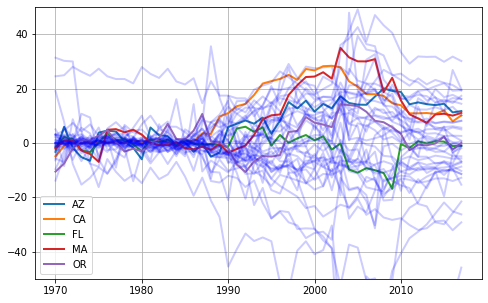

In [40]:
outputstates = {}
diffarray = []
for ss in statesid:
    try:
        d = np.loadtxt('./scripts/output_synth/all_lag/%s_outcome.txt'%ss).T
        outputstates[ss] = d
        #     diffarray.append(d[0]-d[1])
        if ss in controlstates:
            diffarray.append(d[1]-d[2])

    except Exception as e: print(e)
    
    
diffarray = np.array(diffarray).astype(float32)

plt.figure(figsize=(8, 5))
for i in range(51):
    if ils[i] in controlstates: 
        try:
            d = outputstates[statesid[i]]
            plt.plot(years, d[1] - d[2], "b-", alpha=0.2, lw=2)
        except:pass
    if ils[i] in taxstates: 
        d = outputstates[statesid[i]]
        plt.plot(years, d[1] - d[2], ls="-", lw=2, label=ils[i])

# plt.errorbar(years, diffarray.mean(axis=0), diffarray.std(axis=0), color='k')
         
d = outputstates['CA']
plt.plot(years, d[0] - d[1], 'k')
# d = outputstates['UT']
# plt.plot(years, d[0] - d[1], 'r')
# plt.xlim(1970, 2000)
plt.legend()
# plt.ylim(-120, 60)
plt.ylim(-50, 50)
plt.grid(which='both')